# Setup

Let's import the modules we need:

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from train import get_pipeline
from train import prepare_data
%matplotlib inline

# Data Exploration

Let's load the data and take a look at what columns we have.

In [2]:
data = pd.read_csv("data/kc_house_data.csv")
display(data.head())

id             date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520  20141013T000000  221900.0         3       1.00         1180   
1  6414100192  20141209T000000  538000.0         3       2.25         2570   
2  5631500400  20150225T000000  180000.0         2       1.00          770   
3  2487200875  20141209T000000  604000.0         4       3.00         1960   
4  1954400510  20150218T000000  510000.0         3       2.00         1680   

   sqft_lot  floors  waterfront  view     ...      grade  sqft_above  \
0      5650     1.0           0     0     ...          7        1180   
1      7242     2.0           0     0     ...          7        2170   
2     10000     1.0           0     0     ...          6         770   
3      5000     1.0           0     0     ...          7        1050   
4      8080     1.0           0     0     ...          8        1680   

   sqft_basement  yr_built  yr_renovated  zipcode      lat     long  \
0              0      1955             0    98178  47.5112 -122.257   
1            400      1951          1991    98125  47.7210 -122.319   
2              0      1933             0    98028  47.7379 -122.233   
3            910      1965             0    98136  47.5208 -122.393   
4              0      1987             0    98074  47.6168 -122.045   

   sqft_living15  sqft_lot15  
0           1340        5650  
1           1690        7639  
2           2720        8062  
3           1360        5000  
4           1800        7503  

[5 rows x 21 columns]

## Zipcode

It makes sense to treat the zipcode as a categorical variable, so we would have to one-hot encode it. Since we have 70 unique zipcodes in the dataset, dimensionality would explode. We need to do something smarter than that.

We can calculate the average of the price per sqft for each zipcode, and replace the zipcode column with that value. This will allow us to have a continuous variable that takes into account the neighborhood.

In [3]:
print("Unique zipcodes: {}".format(len(data.zipcode.unique())))

Unique zipcodes: 70


## Price

Let's examine how the skewness of price vs price per sqft looks, and how log transforming it changes that.

('Skewness of price/sqft:', 4.023789858140135)
('Skewness of log transformed price/sqft:', 0.42804680472976364)
('Skewness of price/sqft:', 1.2480521920494403)
('Skewness of log transformed price/sqft:', 0.14531154545144953)


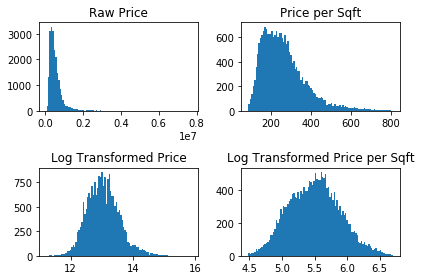

In [4]:
from scipy.stats import skew

fixed_data = data.assign(price_per_sqft=data.price / data.sqft_living)


def create_price_hist(ax, title, data):
    ax.hist(data, bins=100)
    ax.set_title(title)

price_log = np.log1p(fixed_data.price)
print("Skewness of price/sqft:", skew(fixed_data.price))
print("Skewness of log transformed price/sqft:", skew(price_log))

price_per_sqft_log = np.log1p(fixed_data.price_per_sqft)
print("Skewness of price/sqft:", skew(fixed_data.price_per_sqft))
print("Skewness of log transformed price/sqft:", skew(price_per_sqft_log))

fig, ((ax_price, ax_per_sqft), (ax_price_log, ax_per_sqft_log)) = plt.subplots(nrows=2, ncols=2)

create_price_hist(ax_price, "Raw Price", fixed_data.price)
create_price_hist(ax_per_sqft, "Price per Sqft", fixed_data.price_per_sqft)
create_price_hist(ax_price_log, "Log Transformed Price", price_log)
create_price_hist(ax_per_sqft_log, "Log Transformed Price per Sqft", price_per_sqft_log)

plt.tight_layout()
plt.show()

# Building the model

Here we prepare the data for use by the algorithms:

In [5]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import expon, uniform
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor, BaggingRegressor

prepared_data = prepare_data(data)

X = prepared_data.drop('price_per_sqft', axis=1)
y = prepared_data['price_per_sqft']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

Next we create pipelines for each other estimators we want to evaluate, and see how they perform:

In [6]:
estimators = [get_pipeline(GradientBoostingRegressor(random_state=42)),
              get_pipeline(AdaBoostRegressor(random_state=42)),
              get_pipeline(RandomForestRegressor(random_state=42))]
scores = map(lambda clf: clf.fit(X_train, y_train).score(X_test, y_test), estimators)
dict(zip(("gradient_boosting", "ada_boost", "random_forest"), scores))

{'ada_boost': 0.47654512137921423,
 'gradient_boosting': 0.77797034981188107,
 'random_forest': 0.76922999519128699}

Since gradient boosting performs best we move on to tune its parameters:

In [7]:
randomized_search = RandomizedSearchCV(
    get_pipeline(GradientBoostingRegressor(random_state=42)),
    param_distributions={"estimator__learning_rate": expon(scale=.03), 
                         "estimator__n_estimators":[100, 500, 700, 800], 
                         "estimator__subsample": uniform(0., 1.) }, 
    random_state=42,
    cv=5)
randomized_search.fit(X_train, y_train)
randomized_search.score(X_test, y_test)

0.81028079137574782

Let's examine the result:

In [8]:
for param in randomized_search.best_params_:
    print("{}: {}".format(param, randomized_search.best_params_[param]))

estimator__subsample: 0.456069984217
estimator__learning_rate: 0.109208986609
estimator__n_estimators: 700


This is the final model:

In [9]:
randomized_search.best_estimator_

Pipeline(memory=None,
     steps=[('zipcode_average', ZipcodeTransformer()), ('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('log', FunctionTransformer(accept_sparse=False, func=<ufunc 'log1p'>,
          inv_kw_args=None, inverse_func=None, kw_args=None,
          pass_y='deprecated', validate=True)), ('estimator...='auto', random_state=42,
             subsample=0.45606998421703593, verbose=0, warm_start=False))])

It's interesting to see what the learning curve looks for our model.

<module 'matplotlib.pyplot' from '/Users/yavpau/Envs/capstone/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

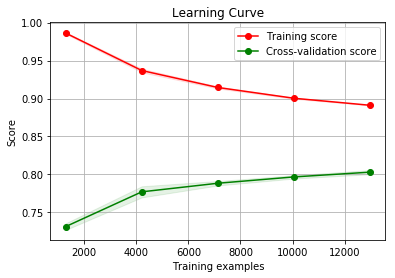

In [10]:
from plot_learning_curve import plot_learning_curve

clf = get_pipeline(GradientBoostingRegressor(learning_rate=0.109208986609, 
                                             n_estimators=700, 
                                             subsample=0.456069984217))
plot_learning_curve(clf, "Learning Curve", X_train, y_train, cv=5, n_jobs=4)